---
title: "Lecture 4: LU factorization, Row pivoting"
author: "Jamie Haddock"
format: 
    revealjs:
        output-file: Lecture4_slides
        slide-number: true
        chalkboard: 
            buttons: false
        preview-links: auto
        logo: figs/hmc.png
        css: input/slides.css
        incremental: true
        smaller: true
        code-fold: true
    html: 
        code-fold: true
    pdf:
        documentclass: article
        toc: true
        number-sections: true
        geometry:
          - top=1in
          - left=1in
          - bottom=1in
          - right=1in
format-links: false
jupyter: julia-1.9
filters: 
  - input/remove-pause.lua
execute:
  echo: true
  eval: true
---

# LU Factorization

## Triangular Products

In [3]:
using LinearAlgebra
L = tril( rand(1:9,3,3) )

3×3 Matrix{Int64}:
 6  0  0
 7  3  0
 7  2  5

In [4]:
U = triu( rand(1:9, 3,3) )

3×3 Matrix{Int64}:
 4  6  9
 0  6  6
 0  0  9

In [10]:
L*U

3×3 Matrix{Int64}:
 24  36   54
 28  60   81
 28  54  120

---

One view of matrix multiplication is as a sum of rank-one matrices formed as *outer products* of corresponding columns of $\mathbf{A}$ and rows of $\mathbf{B}$, $$\mathbf{C} = \sum_{k = 1}^n \mathbf{A}_{:k} \mathbf{B}_{k:}.$$

In [5]:
L[:,1]*U[1,:]'

3×3 Matrix{Int64}:
 24  36  54
 28  42  63
 28  42  63

Only the first outer product contributes to the first row and column of the product $\mathbf{L}\mathbf{U}$.

---

In [6]:
L[:,2]*U[2,:]'

3×3 Matrix{Int64}:
 0   0   0
 0  18  18
 0  12  12

In [7]:
L[:,3]*U[3,:]'

3×3 Matrix{Int64}:
 0  0   0
 0  0   0
 0  0  45

The triangular zero structures of these matrices create rows and columns of zeros in the inner product.

## Triangular factorization

When factorizing $n \times n$ matrix $\mathbf{A}$ into a triangular product $\mathbf{L}\mathbf{U}$, note that $\mathbf{L}$ and $\mathbf{U}$ have $n^2 + n > n^2$ entries, so we may choose the diagonal entries of $\mathbf{L}$ to be one (a **unit lower triangular** matrix). 

In [11]:
A₁ = [
    2 0 4 3
    -4 5 -7 -10
    1 15 2 -4.5
    -2 0 2 -13
];
L = diagm(ones(4))
U = zeros(4,4);

[Since $L_{11} = 1$, the first row of $\mathbf{U}$ is the first row of $\mathbf{A}$.]{.content-hidden when-format='revealjs' when-format='pptx'} 

In [12]:
U[1,:] = A₁[1,:]
U

4×4 Matrix{Float64}:
 2.0  0.0  4.0  3.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

---

[The rest of the first column of $\mathbf{L}$ can be computed from the first column of $\mathbf{A}$ since only the first outer product contributes to this portion of $\mathbf{A}$.]{.content-hidden when-format='revealjs' when-format='pptx'} 

In [13]:
L[:,1] = A₁[:,1]/U[1,1]
L

4×4 Matrix{Float64}:
  1.0  0.0  0.0  0.0
 -2.0  1.0  0.0  0.0
  0.5  0.0  1.0  0.0
 -1.0  0.0  0.0  1.0

In [14]:
A₂ = A₁ - L[:,1]*U[1,:]'

4×4 Matrix{Float64}:
 0.0   0.0  0.0    0.0
 0.0   5.0  1.0   -4.0
 0.0  15.0  0.0   -6.0
 0.0   0.0  6.0  -10.0

---

[Using the same logic as before, we may set the second rows and columns of $\mathbf{U}$ and $\mathbf{L}$ using $\mathbf{A}_2$.]{.content-hidden when-format='revealjs' when-format='pptx'} 

In [16]:
U[2,:] = A₂[2,:]
L[:,2] = A₂[:,2]/U[2,2];

In [17]:
A₃ = A₂ - L[:,2]*U[2,:]'

4×4 Matrix{Float64}:
 0.0  0.0   0.0    0.0
 0.0  0.0   0.0    0.0
 0.0  0.0  -3.0    6.0
 0.0  0.0   6.0  -10.0

---

In [18]:
U[3,:] = A₃[3,:]
L[:,3] = A₃[:,3]/U[3,3]
A₄ = A₃ - L[:,3]*U[3,:]'

4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  2.0

In [19]:
U[4,4] = A₄[4,4]

A₁ - L*U

4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

. . .

::: {.callout-note icon=false}
## Definition: LU factorization
Given $n \times n$ matrix $\mathbf{A}$, its **LU factorization** is $$\mathbf{A} = \mathbf{L}\mathbf{U},$$ where $\mathbf{L}$ is a unit lower triangular matrix and $\mathbf{U}$ is an upper triangular matrix.
:::

---

In [20]:
"""
    lufact(A)

Compute the LU factorization of square matrix `A`, returning the factors.
"""
function lufact(A)
    n = size(A,1)
    L = diagm(ones(n))  #ones on diagonal, zeros elsewhere
    U = zeros(n,n)
    Ak = float(copy(A))

    #Reduction by outer products
    for k in 1:n-1
        U[k,:] = Ak[k,:]
        L[:,k] = Ak[:,k]/U[k,k]
        Ak -= L[:,k]*U[k,:]'
    end
    U[n,n] = Ak[n,n]
    return LowerTriangular(L),UpperTriangular(U)
end

lufact

## Solving linear systems with LU

We can solve $\mathbf{A}\mathbf{x} = \mathbf{b}$ with three steps:

1. Factor $\mathbf{A} = \mathbf{L}\mathbf{U}$.
2. Solve $\mathbf{L}\mathbf{z} = \mathbf{b}$ for $\mathbf{z}$ using forward substitution.
3. Solve $\mathbf{U}\mathbf{x} = \mathbf{z}$ for $\mathbf{x}$ using backward substitution.

. . .

::: {.callout-warning icon=false}
## Lemma: 
Solving a triangular $n \times n$ system by forward or backward substitution takes $\mathcal{O}(n^2)$ flops asymptotically.
:::

[Let $f(n)$ and $g(n)$ be positive-valued functions.  We say $f(n) = \mathcal{O}(g(n))$ as $n \rightarrow \infty$ if $f(n)/g(n)$ is bounded above as $n \rightarrow \infty$.]{.content-hidden when-format='revealjs' when-format='pptx'} 

. . .

::: {.callout-warning icon=false}
## Theorem: Efficiency of LU factorization
The LU factorization of an $n \times n$ matrix takes $\mathcal{O}(n^3)$ flops as $n \rightarrow \infty$.  This dominates the cost of solving an $n \times n$ system.
:::

---

In [21]:
lu(randn(3,3)); #throwaway to force compilation of the lu function code_llvm

n = 400:400:4000
t = []
for n in n
    A = randn(n,n)
    time = @elapsed for j in 1:12; lu(A); end
    push!(t,time)
end

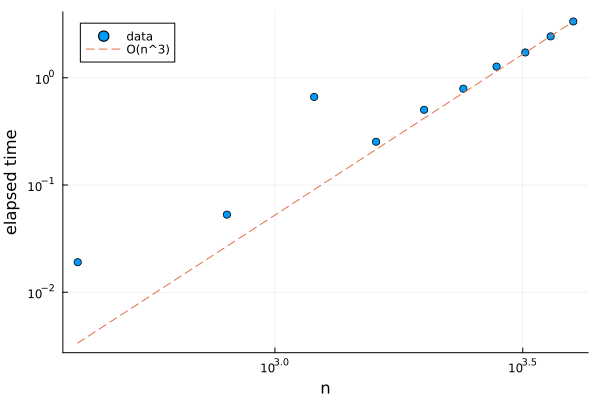

In [24]:
using Plots

scatter(n,t,label="data",legend=:topleft,
    xaxis=(:log10,"n"), yaxis=(:log10,"elapsed time"))
plot!(n,t[end]*(n/n[end]).^3,l=:dash,label="O(n^3)")

# Row pivoting

In [25]:
A = [2 0 4 3; -4 5 -7 -10; 1 15 2 -4.5; -2 0 2 -13];
L,U = lufact(A);
L

4×4 LowerTriangular{Float64, Matrix{Float64}}:
  1.0   ⋅     ⋅    ⋅ 
 -2.0  1.0    ⋅    ⋅ 
  0.5  3.0   1.0   ⋅ 
 -1.0  0.0  -2.0  1.0

In [26]:
A[[2,4],:] = A[[4,2],:]
L,U = lufact(A);
L

4×4 LowerTriangular{Float64, Matrix{Float64}}:
  1.0     ⋅      ⋅    ⋅ 
 -1.0  NaN       ⋅    ⋅ 
  0.5   Inf   NaN     ⋅ 
 -2.0   Inf   NaN    1.0

After swapping the 2nd and 4th rows of $\mathbf{A}$, the matrix is still nonsingular, but now the LU factorization fails due to dividing by a diagonal element of $\mathbf{U}$ that is zero.  The diagonal element of $\mathbf{U}$ by which we divide is called the **pivot element** of its column.

## Choosing a pivot

In order to avoid a zero pivot in the factorization process, we use a technique known as **row pivoting**: when performing elimination in the $j$th column, choose as the pivot the element in column $j$ that is largest in absolute value.

In [27]:
A₁ = [2 0 4 3; -2 0 2 -13; 1 15 2 -4.5; -4 5 -7 -10]

4×4 Matrix{Float64}:
  2.0   0.0   4.0    3.0
 -2.0   0.0   2.0  -13.0
  1.0  15.0   2.0   -4.5
 -4.0   5.0  -7.0  -10.0

---

In [28]:
i = argmax( abs.(A₁[:,1]) )

4

In [29]:
L,U = zeros(4,4),zeros(4,4)
U[1,:] = A₁[i,:]
L[:,1]= A₁[:,1]/U[1,1]
A₂ = A₁ - L[:,1]*U[1,:]'

4×4 Matrix{Float64}:
 0.0   2.5   0.5   -2.0
 0.0  -2.5   5.5   -8.0
 0.0  16.25  0.25  -7.0
 0.0   0.0   0.0    0.0

In [30]:
@show i = argmax( abs.(A₂[:,2]) )
U[2,:] = A₂[i,:]
L[:,2] = A₂[:,2]/U[2,2]
A₃ = A₂ - L[:,2]*U[2,:]'

i = argmax(abs.(A₂[:, 2])) = 3


4×4 Matrix{Float64}:
 0.0  0.0  0.461538  -0.923077
 0.0  0.0  5.53846   -9.07692
 0.0  0.0  0.0        0.0
 0.0  0.0  0.0        0.0

---

In [32]:
@show i = argmax( abs.(A₃[:,3]) )
U[3,:] = A₃[i,:]
L[:,3] = A₃[:,3]/U[3,3]
A₄ = A₃ - L[:,3]*U[3,:]'

i = argmax(abs.(A₃[:, 3])) = 2


4×4 Matrix{Float64}:
 0.0  0.0  0.0  -0.166667
 0.0  0.0  0.0   0.0
 0.0  0.0  0.0   0.0
 0.0  0.0  0.0   0.0

In [33]:
@show i = argmax( abs.(A₄[:,4]) )
U[4,:] = A₄[i,:]
L[:,4] = A₄[:,4]/U[4,4];

i = argmax(abs.(A₄[:, 4])) = 1


---

In [34]:
A₁ - L*U

4×4 Matrix{Float64}:
 0.0  -1.38778e-16  0.0  0.0
 0.0   1.38778e-16  0.0  0.0
 0.0   0.0          0.0  0.0
 0.0   0.0          0.0  0.0

In [35]:
U

4×4 Matrix{Float64}:
 -4.0   5.0   -7.0      -10.0
  0.0  16.25   0.25      -7.0
  0.0   0.0    5.53846   -9.07692
  0.0   0.0    0.0       -0.166667

In [36]:
L

4×4 Matrix{Float64}:
 -0.5    0.153846  0.0833333   1.0
  0.5   -0.153846  1.0        -0.0
 -0.25   1.0       0.0        -0.0
  1.0    0.0       0.0        -0.0

. . .

$\mathbf{L}$ doesn't have the required lower triangular structure!

---

::: {.callout-warning icon=false}
## Theorem: Row pivoting
The row-pivoted LU factorization runs to completion if and only if the original matrix is invertible.
:::

. . . 

Linear systems with uninvertible matrices have either no solution or infinitely many.  We need techniques other than LU factorization to deal with such systems.

## Permutations

The $\mathbf{L}$ matrix calculated in the last example is not lower-triangular, but is if we simply reverse the rows.  In fact, it will be true in general that the $\mathbf{L}$ calculated will be lower-triangular after a permutation of the rows.  

[We can think of the algorithm as behaving exactly the original LU factorization technique (without row pivoting) if we reorder the rows of the original matrix in order of the row pivot indices identified in each of the steps.  (For our example, this would be putting row 4 at the top, then row 3, then row 2, and then row1.)]{.content-hidden when-format='revealjs' when-format='pptx'} 

In [37]:
B = A[ [4,3,2,1], : ]
L, U = lufact(B);

In [38]:
U

4×4 UpperTriangular{Float64, Matrix{Float64}}:
 -4.0   5.0   -7.0      -10.0
   ⋅   16.25   0.25      -7.0
   ⋅     ⋅     5.53846   -9.07692
   ⋅     ⋅      ⋅        -0.166667

In [39]:
L

4×4 LowerTriangular{Float64, Matrix{Float64}}:
  1.0     ⋅         ⋅          ⋅ 
 -0.25   1.0        ⋅          ⋅ 
  0.5   -0.153846  1.0         ⋅ 
 -0.5    0.153846  0.0833333  1.0

$\mathbf{L}$ is the same matrix as before, but with the rows permuted to reverse order!

---

::: {.callout-warning icon=false}
## Theorem: PLU factorization
Given $n \times n$ matrix $\mathbf{A}$, the **PLU factorization** is a unit lower triangular matrix $\mathbf{L}$, an upper triangular matrix $\mathbf{U}$, and a permutation $i_1, \cdots, i_n$ of the integers $1, \cdots, n$ such that $$\tilde{\mathbf{A}} = \mathbf{L}\mathbf{U},$$ where rows $1, \cdots, n$ of $\tilde{\mathbf{A}}$ are rows $i_1, \cdots, i_n$ of $\mathbf{A}$.
:::

In [51]:
"""
    plufact(A)

Compute the PLU factorization of square matrix `A`, returning factors and row permutation.
"""
function plufact(A)
    n = size(A,1)
    L,U,p,Ak = zeros(n,n),zeros(n,n),fill(0,n),float(copy(A))

    #Reduction by outer products
    for k in 1:n-1
        p[k] = argmax(abs.(Ak[:,k]))
        U[k,:] = Ak[p[k],:]
        L[:,k] = Ak[:,k]/U[k,k]
        Ak -= L[:,k]*U[k,:]'
    end
    p[n] = argmax(abs.(Ak[:,n]))
    U[n,n] = Ak[p[n],n]
    L[:,n] = Ak[:,n]/U[n,n]
    return LowerTriangular(L[p,:]),U,p
end

plufact

## Linear systems

In [52]:
A = rand(1:20,4,4)
L,U,p = plufact(A)
A[p,:] - L*U

4×4 Matrix{Float64}:
 0.0  0.0   0.0          0.0
 0.0  0.0   0.0          0.0
 0.0  0.0   0.0          0.0
 0.0  0.0  -8.88178e-16  3.55271e-15

In [53]:
using FundamentalsNumericalComputation;

b = rand(4)
z = FNC.forwardsub(L,b[p])
x = FNC.backsub(U,z)

4-element Vector{Float64}:
  0.02074712679808451
  0.029105191666686472
 -0.0019461283650047195
 -0.019593097289861985

In [54]:
b - A*x

4-element Vector{Float64}:
 1.1102230246251565e-16
 1.1102230246251565e-16
 0.0
 5.551115123125783e-17

## Stability

The reason for choosing the largest magnitude pivot during row-pivoting is numerical stability!  

. . .

Consider the example $$\mathbf{A} = \begin{bmatrix} -\epsilon & 1 \\ 1 & -1 \end{bmatrix}.$$

In [56]:
ϵ = 1e-12
A = [-ϵ 1; 1 -1]
b = A*[1,1];

In [57]:
L,U = lufact(A)
x = FNC.backsub( U, FNC.forwardsub(L,b) )

2-element Vector{Float64}:
 0.9999778782798785
 1.0

We have only five digits of accuracy.  This gets even worse if $\epsilon$ is smaller!

---

In [58]:
ϵ = 1e-20
A = [-ϵ 1; 1 -1]
b = A*[1,1]
L,U = lufact(A)
x = FNC.backsub( U, FNC.forwardsub(L,b) )

2-element Vector{Float64}:
 -0.0
  1.0

This is not due to ill-conditioning of the problem -- a solution with PLU factorization works perfectly! (PLU factorization is used under the hood in the `\` operator.)

In [59]:
A\b

2-element Vector{Float64}:
 1.0
 1.0

<!--
[verbose test]{.content-hidden when-format="revealjs" when-format="pptx"}

::: {.callout-caution icon=false}
## Exercise: 

:::

<details><summary>Answer:</summary> </details>


::: {.callout-note icon=false}
## Definition: 
 
:::


::: {.callout-tip icon=false}
## Note: 
 
:::
-->